In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
BASE_PATH = "c:\\Users\\USER\\Downloads\\"

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import ast

In [3]:
def read_csv(file_path):
    """
    convert csv -> dataframe
    """
    print("loading csv file...", end='\t')
    # read csv file
    df = pd.read_csv(file_path)
    print("Done.")

    print("convert string into list...")
    for col_name, col_type in type_list.items():
        print(f"\t{col_name}...", end='\t')
        df[col_name] = df[col_name].apply(lambda x: np.array(x.split(","), dtype=col_type))
        print("Done.")
    print("Done.")

    return df

In [4]:
# data 선택
FT_UNMON = True
FT_MON = True

# label type - False 인 경우 monitored(1), unmonitored(-1)
FT_MULTI_LABEL = True

In [5]:
def load_pickle_file(file_name):
    # Load the pickle file
    print("Loading datafile...")
    with open(BASE_PATH + file_name, 'rb') as fi: # Path to mon_standard.pkl in Colab
        data = pickle.load(fi)

    print("Done.")
    return data

In [6]:
SITE_CNT = 95
URL_PER_SITE = 10

def parse_dataset(mon_data, unmon_data):
    print("parsing dataset...")
    dataset = []
    label = []

    if mon_data:
        if FT_MULTI_LABEL:
            label = [i for i in range(95) for _ in range(200)]
        else:
            label = [1] * 95 * 200

        for i in range(SITE_CNT):
            temp = []
            for j in range(URL_PER_SITE):
                temp.append(mon_data[i*URL_PER_SITE + j])
            dataset.append(list(chain.from_iterable(temp)))

    if unmon_data:
        label.extend([-1]*10000)
        dataset.append(unmon_data)


    dataset = list(chain.from_iterable(dataset))
    print("Done.")
    return dataset, label


In [7]:

if FT_MON:
    mon_data = load_pickle_file("mon_standard.pkl")
else:
    mon_data = None
if FT_UNMON:
    unmon_data = load_pickle_file("unmon_standard10.pkl")
else:
    unmon_data = None

dataset, label = parse_dataset(mon_data, unmon_data)
del mon_data
del unmon_data

Loading datafile...
Done.
Loading datafile...
Done.
parsing dataset...
Done.


In [8]:
PACKET_SIZE = 512

# feature 선택
# continuous
FT_TIMESTAMPS = True

FT_DIRECTION = True # 방향만 표기 [1. -1, 1, 1, ...]
FT_PACKET_SIZE = True # packet의 size로 표기 [512, -512, 512, 512, ...]


# busrt와 cumulative의 경우, Packet size를 반영하여 계산할 수도 있지만 Tor에서는 모든 패킷이 512 단위이므로, 그냥 scale을 줄여서 사용할 수도 있을거 같습니다.
# (저희에게 주어진 데이터의 경우 모두 512이므로 그냥 방향만으로 계산한다고 생각해도 무방)
FT_BURST_DIR = True # [1, -1, 1, 2, ...]
FT_BURST_SIZE = True # burst_dir에 packet size를 반영한 것 (burst_dir * 512)
FT_CUMULATIVE_DIR = True # [1, 0, 1, 2, ...]
FT_CUMULATIVE_SIZE = True # cumulative dir에 packet size를 반영한 것 (cumulative_dir * 512)

#categorical
FT_CATEGORICAL = True

In [9]:
def calculate_burst_pattern(arr):
    if not arr:
        return []
    prev = arr[0]
    result = []

    for dir in arr[1:]:
        if (prev * dir) > 0:
            prev += dir
        else:
            result.append(prev)
            prev = dir

    result.append(prev)
    return result


def extract_features(direction_arr,
                     ft_packet_size=FT_PACKET_SIZE,
                     ft_burst_dir=FT_BURST_DIR,
                     ft_burst_size=FT_BURST_SIZE,
                     ft_cumulative_dir=FT_CUMULATIVE_DIR,
                     ft_cumulative_size=FT_CUMULATIVE_SIZE,
                     ft_categorical=FT_CATEGORICAL):

    result = dict()

    if ft_packet_size:
        result["packet_size"] = list(map(lambda x:np.array(x)*PACKET_SIZE, direction_arr))

    if ft_burst_dir or ft_burst_size:
        burst = list(map(calculate_burst_pattern, direction_arr))
        if ft_burst_dir:
            result["burst_dir"] = burst
        if ft_burst_size:
            result["burst_size"] = list(map(lambda x: np.array(x) * PACKET_SIZE, burst))

    if ft_cumulative_dir or ft_cumulative_size:
        cumulative = list(map(lambda x: np.cumsum(x), direction_arr))
        if ft_cumulative_dir:
            result["cumulative_dir"] = cumulative
        else:
            result["cumulative_size"] = list(map(lambda x:x * PACKET_SIZE, cumulative))

    if ft_categorical:
        result["count"] = list(map(lambda x:len(x), direction_arr))
        result["incoming_count"] = list(map(lambda x:x.count(-1), direction_arr))
        result["incoming_rate"] = np.array(result["incoming_count"]) / np.array(result["count"])

        result["outgoing_count"] = np.array(result["count"]) - np.array(result["incoming_count"])
        result["outgoing_rate"] = np.array(result["outgoing_count"]) / np.array(result["count"])
    return result

In [10]:
timestamps = []
direction = []

for data in dataset:
    timestamps.append(abs(np.array(data)))
    direction.append(list(map(lambda x: 1 if x > 0 else -1, data)))

df = pd.DataFrame({"label": label})

if FT_TIMESTAMPS:
    df["timestamps"] = timestamps
if FT_DIRECTION:
    df["direction"] = direction

df = df.assign(**extract_features(direction))
del label
del timestamps
del direction
df.head()

,label,timestamps,direction,packet_size,burst_dir,burst_size,cumulative_dir,count,incoming_count,incoming_rate,outgoing_count,outgoing_rate
0,0,"[0.0, 0.14, 0.14, 0.31, 0.31, 0.51, 0.51, 0.51...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1421,1300,0.914849,121,0.085151
1,0,"[0.0, 0.13, 0.13, 0.31, 0.77, 1.11, 1.11, 1.11...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",518,438,0.845560,80,0.154440
2,0,"[0.0, 0.11, 0.11, 0.23, 0.97, 1.11, 1.11, 1.11...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1358,1240,0.913108,118,0.086892
3,0,"[0.0, 0.27, 0.27, 0.6, 0.6, 0.88, 0.89, 0.89, ...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1446,1324,0.915629,122,0.084371
4,0,"[0.0, 0.11, 0.11, 0.36, 0.36, 0.6, 0.6, 0.6, 0...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1406,1291,0.918208,115,0.081792


In [11]:
INITIAL_SIZE = 10

FT_INITIAL_BURST_DIR = True
FT_INITIAL_BURST_SIZE = True
FT_INITIAL_CUMULATIVE_DIR = True
FT_INITIAL_CUMULATIVE_SIZE = True

In [12]:
def extract_initial_fetaure(direction_arr, size):
  
    initial_direction = list(map(lambda x:x[:size], direction_arr))
    initial_direction = initial_direction+[0]* (size - len(initial_direction))
    features = extract_features(initial_direction,
                            ft_packet_size=False,
                            ft_burst_dir=FT_INITIAL_BURST_DIR,
                            ft_burst_size=FT_INITIAL_BURST_SIZE,
                            ft_cumulative_dir=FT_INITIAL_CUMULATIVE_DIR,
                            ft_cumulative_size=FT_INITIAL_CUMULATIVE_SIZE,
                            ft_categorical=True)

    result = dict()

    for key in features:
        result[f"initial_{key}_{size}"] = features[key]

    return result

In [13]:
# dataframe에 추가하기
df = df.assign(**extract_initial_fetaure(df["direction"], 10))
df = df.assign(**extract_initial_fetaure(df["direction"], 20))
df = df.assign(**extract_initial_fetaure(df["direction"], 30))
df = df.assign(**extract_initial_fetaure(df["direction"], 40))
df = df.assign(**extract_initial_fetaure(df["direction"], 50))

df.head()

,label,timestamps,direction,packet_size,burst_dir,burst_size,cumulative_dir,count,incoming_count,incoming_rate,...,initial_outgoing_count_40,initial_outgoing_rate_40,initial_burst_dir_50,initial_burst_size_50,initial_cumulative_dir_50,initial_count_50,initial_incoming_count_50,initial_incoming_rate_50,initial_outgoing_count_50,initial_outgoing_rate_50
0,0,"[0.0, 0.14, 0.14, 0.31, 0.31, 0.51, 0.51, 0.51...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1421,1300,0.914849,...,14,0.350,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,35,0.70,15,0.30
1,0,"[0.0, 0.13, 0.13, 0.31, 0.77, 1.11, 1.11, 1.11...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",518,438,0.845560,...,13,0.325,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,36,0.72,14,0.28
2,0,"[0.0, 0.11, 0.11, 0.23, 0.97, 1.11, 1.11, 1.11...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1358,1240,0.913108,...,12,0.300,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,37,0.74,13,0.26
3,0,"[0.0, 0.27, 0.27, 0.6, 0.6, 0.88, 0.89, 0.89, ...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1446,1324,0.915629,...,12,0.300,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,36,0.72,14,0.28
4,0,"[0.0, 0.11, 0.11, 0.36, 0.36, 0.6, 0.6, 0.6, 0...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1406,1291,0.918208,...,13,0.325,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,36,0.72,14,0.28


In [14]:
'''def convert_lists_to_arrays(df):
    # 함수를 각 열에 적용하여 리스트를 배열로 변환
    for column in df.columns:
        if isinstance(df[column][0], list):
            df[column] = df[column].apply(np.array)
    return df

# 변환 적용
df = convert_lists_to_arrays(df)
'''
def convert_arrays_to_lists(df):
    for column in df.columns:
        if isinstance(df[column][0], np.ndarray):
            df[column] = df[column].apply(lambda x: x.tolist())
    return df
df = convert_arrays_to_lists(df)

In [ ]:
df.head()

,label,timestamps,direction,packet_size,burst_dir,burst_size,cumulative_dir,count,incoming_count,incoming_rate,...,initial_outgoing_count_40,initial_outgoing_rate_40,initial_burst_dir_50,initial_burst_size_50,initial_cumulative_dir_50,initial_count_50,initial_incoming_count_50,initial_incoming_rate_50,initial_outgoing_count_50,initial_outgoing_rate_50
0,0,"[0.0, 0.14, 0.14, 0.31, 0.31, 0.51, 0.51, 0.51...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1421,1300,0.914849,...,14,0.350,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,35,0.70,15,0.30
1,0,"[0.0, 0.13, 0.13, 0.31, 0.77, 1.11, 1.11, 1.11...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",518,438,0.845560,...,13,0.325,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,36,0.72,14,0.28
2,0,"[0.0, 0.11, 0.11, 0.23, 0.97, 1.11, 1.11, 1.11...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1358,1240,0.913108,...,12,0.300,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,37,0.74,13,0.26
3,0,"[0.0, 0.27, 0.27, 0.6, 0.6, 0.88, 0.89, 0.89, ...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1446,1324,0.915629,...,12,0.300,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,36,0.72,14,0.28
4,0,"[0.0, 0.11, 0.11, 0.36, 0.36, 0.6, 0.6, 0.6, 0...","[-1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -...","[-512, -512, 512, -512, 512, -512, 512, 512, -...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",1406,1291,0.918208,...,13,0.325,"[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...",50,36,0.72,14,0.28


# MultiClass

In [17]:
'''label                          int64
timestamps                    object
direction                     object
packet_size                   object
burst_dir                     object
burst_size                    object
cumulative_dir                object
count                          int64
incoming_count                 int64
incoming_rate                float64
outgoing_count                 int32
outgoing_rate                float64
initial_burst_dir_10          object
initial_burst_size_10         object
initial_cumulative_dir_10     object
initial_count_10               int64
initial_incoming_count_10      int64
initial_incoming_rate_10     float64
initial_outgoing_count_10      int32
initial_outgoing_rate_10     float64
...
initial_burst_dir_50          object
initial_burst_size_50         object
initial_cumulative_dir_50     object
initial_count_50               int64
initial_incoming_count_50      int64
initial_incoming_rate_50     float64
initial_outgoing_count_50      int32
initial_outgoing_rate_50     float64
'''
feature_nonseq =['count','incoming_count','incoming_rate','outgoing_count','outgoing_rate',
                 'initial_count_10','initial_incoming_count_10','initial_incoming_rate_10','initial_outgoing_count_10','initial_outgoing_rate_10',
                 'initial_count_20','initial_incoming_count_20','initial_incoming_rate_20','initial_outgoing_count_20','initial_outgoing_rate_20',
                 'initial_count_30','initial_incoming_count_30','initial_incoming_rate_30','initial_outgoing_count_30','initial_outgoing_rate_30',
                 'initial_count_40','initial_incoming_count_40','initial_incoming_rate_40','initial_outgoing_count_40','initial_outgoing_rate_40',
                 'initial_count_50','initial_incoming_count_50','initial_incoming_rate_50','initial_outgoing_count_50','initial_outgoing_rate_50'
                ]
feature_initial=[  'initial_burst_dir_10', 'initial_burst_size_10', 
                   'initial_cumulative_dir_10', 'initial_burst_dir_20', 'initial_burst_size_20', 
                   'initial_cumulative_dir_20', 'initial_burst_dir_30', 'initial_burst_size_30', 
                   'initial_cumulative_dir_30', 'initial_burst_dir_40', 'initial_burst_size_40', 
                   'initial_cumulative_dir_40', 'initial_burst_dir_50', 'initial_burst_size_50', 
                   'initial_cumulative_dir_50'
                   ]
festure_seq=['timestamps', 'direction', 'packet_size', 'burst_dir', 'burst_size', 'cumulative_dir',]

### 렌덤 포레스트


In [14]:
X = df[feature_nonseq]
y = df['label']
X

,count,incoming_count,incoming_rate,outgoing_count,outgoing_rate,initial_count_10,initial_incoming_count_10,initial_incoming_rate_10,initial_outgoing_count_10,initial_outgoing_rate_10,...,initial_count_40,initial_incoming_count_40,initial_incoming_rate_40,initial_outgoing_count_40,initial_outgoing_rate_40,initial_count_50,initial_incoming_count_50,initial_incoming_rate_50,initial_outgoing_count_50,initial_outgoing_rate_50
0,1421,1300,0.914849,121,0.085151,10,6,0.6,4,0.4,...,40,26,0.650,14,0.350,50,35,0.70,15,0.30
1,518,438,0.845560,80,0.154440,10,6,0.6,4,0.4,...,40,27,0.675,13,0.325,50,36,0.72,14,0.28
2,1358,1240,0.913108,118,0.086892,10,6,0.6,4,0.4,...,40,28,0.700,12,0.300,50,37,0.74,13,0.26
3,1446,1324,0.915629,122,0.084371,10,6,0.6,4,0.4,...,40,28,0.700,12,0.300,50,36,0.72,14,0.28
4,1406,1291,0.918208,115,0.081792,10,6,0.6,4,0.4,...,40,27,0.675,13,0.325,50,36,0.72,14,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28995,4593,4180,0.910081,413,0.089919,10,6,0.6,4,0.4,...,40,30,0.750,10,0.250,50,40,0.80,10,0.20
28996,5110,4663,0.912524,447,0.087476,10,6,0.6,4,0.4,...,40,26,0.650,14,0.350,50,35,0.70,15,0.30
28997,361,302,0.836565,59,0.163435,10,7,0.7,3,0.3,...,40,29,0.725,11,0.275,50,39,0.78,11,0.22
28998,509,413,0.811395,96,0.188605,10,7,0.7,3,0.3,...,40,27,0.675,13,0.325,50,35,0.70,15,0.30


c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

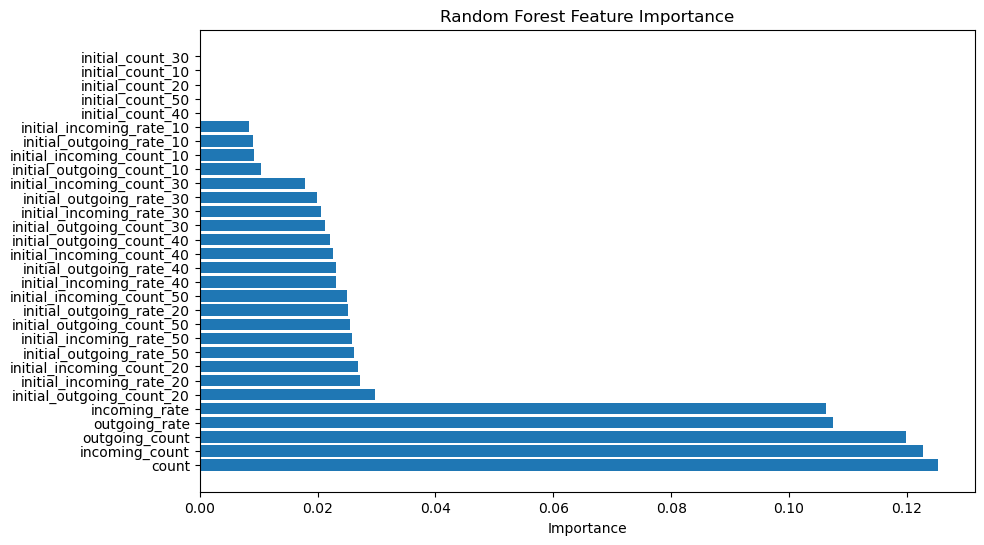

In [15]:
# 렌덤포레스트, 데이터 중요도
# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델을 훈련 데이터에 맞춤
rf_model.fit(X, y)

# 각 feature의 중요도를 추출
feature_importances = rf_model.feature_importances_

# 중요도를 기준으로 feature를 내림차순으로 정렬
feature_importance_df = pd.DataFrame({'Feature': feature_nonseq, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 중요도를 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()

In [16]:
del rf_model

## KNN 모델

In [17]:
X = df[feature_nonseq]
y = df['label']

In [18]:
X

,count,incoming_count,incoming_rate,outgoing_count,outgoing_rate,initial_count_10,initial_incoming_count_10,initial_incoming_rate_10,initial_outgoing_count_10,initial_outgoing_rate_10,...,initial_count_40,initial_incoming_count_40,initial_incoming_rate_40,initial_outgoing_count_40,initial_outgoing_rate_40,initial_count_50,initial_incoming_count_50,initial_incoming_rate_50,initial_outgoing_count_50,initial_outgoing_rate_50
0,1421,1300,0.914849,121,0.085151,10,6,0.6,4,0.4,...,40,26,0.650,14,0.350,50,35,0.70,15,0.30
1,518,438,0.845560,80,0.154440,10,6,0.6,4,0.4,...,40,27,0.675,13,0.325,50,36,0.72,14,0.28
2,1358,1240,0.913108,118,0.086892,10,6,0.6,4,0.4,...,40,28,0.700,12,0.300,50,37,0.74,13,0.26
3,1446,1324,0.915629,122,0.084371,10,6,0.6,4,0.4,...,40,28,0.700,12,0.300,50,36,0.72,14,0.28
4,1406,1291,0.918208,115,0.081792,10,6,0.6,4,0.4,...,40,27,0.675,13,0.325,50,36,0.72,14,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28995,4593,4180,0.910081,413,0.089919,10,6,0.6,4,0.4,...,40,30,0.750,10,0.250,50,40,0.80,10,0.20
28996,5110,4663,0.912524,447,0.087476,10,6,0.6,4,0.4,...,40,26,0.650,14,0.350,50,35,0.70,15,0.30
28997,361,302,0.836565,59,0.163435,10,7,0.7,3,0.3,...,40,29,0.725,11,0.275,50,39,0.78,11,0.22
28998,509,413,0.811395,96,0.188605,10,7,0.7,3,0.3,...,40,27,0.675,13,0.325,50,35,0.70,15,0.30


In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.4, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
del X_temp
del y_temp

K = 1: Accuracy = 0.4651724137931034
K = 2: Accuracy = 0.4739655172413793
K = 3: Accuracy = 0.49344827586206896
K = 4: Accuracy = 0.4886206896551724
K = 5: Accuracy = 0.4860344827586207
K = 6: Accuracy = 0.48413793103448277
K = 7: Accuracy = 0.4818965517241379
K = 8: Accuracy = 0.4824137931034483
K = 9: Accuracy = 0.4810344827586207
K = 10: Accuracy = 0.4774137931034483


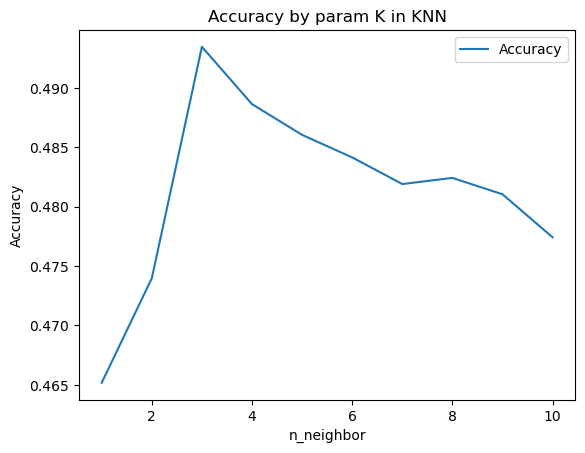

In [33]:
#N 의 사이즈에 따른 Knn 모델의 성능 비교
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

k_list = [i for i in range(1, 11)]
accuracy = []


for k in k_list:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    
    # 모델 예측
    y_pred = knn_model.predict(X_val)
    
    # 정확도 계산 및 저장
    accuracy.append(accuracy_score(y_val, y_pred))


    # 출력
    print(f"K = {k}: Accuracy = {accuracy[-1]}")


# 정확도 그래프 플로팅
plt.plot(k_list, accuracy, label='Accuracy')
plt.xlabel("n_neighbor")
plt.ylabel("Accuracy")
plt.title("Accuracy by param K in KNN")
plt.legend()
plt.show()

In [79]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

model_param_set_grid={
    KNeighborsClassifier():{
        "n_neighbors": [i for i in range(1,10)],
        "metric":["euclidean","manhattan","chebyshev","hamming","jaccard"]
    }
}
max_score=0
best_param = None

for model, param in model_param_set_grid.items():
    clf = GridSearchCV(model,param)
    clf.fit(X_train,y_train)
    pred_y = clf.predict(X_val)
    score = f1_score(y_val,pred_y,average="micro")
    if max_score<score:
        max_score=score
        best_param=clf.best_params_

print(f"파라미터 : {best_param} \n 최고점수: {max_score}")
print("조정 없을 때")
model = KNeighborsClassifier()
model.fit(X_train,y_train)
print(model.score(X_val,y_val))

ValueError: 
All the 225 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\neighbors\_base.py", line 454, in _fit
    X, y = self._validate_data(
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\USER\anaconda3\envs\PyTorch_env\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: setting an array element with a sequence.


# 시퀀스 데이터


In [ ]:
X = df.drop('labels')
y = df['labels']
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.4, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)
del X_temp
del y_temp

In [99]:
X

,initial_burst_dir_10,initial_burst_size_10,initial_cumulative_dir_10,initial_burst_dir_20,initial_burst_size_20,initial_cumulative_dir_20,initial_burst_dir_30,initial_burst_size_30,initial_cumulative_dir_30,initial_burst_dir_40,initial_burst_size_40,initial_cumulative_dir_40,initial_burst_dir_50,initial_burst_size_50,initial_cumulative_dir_50
0,"[-2, 1, -1, 1, -1, 2, -2]","[-1024, 512, -512, 512, -512, 1024, -1024]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2]","[-2, 1, -1, 1, -1, 2, -12]","[-1024, 512, -512, 512, -512, 1024, -6144]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3]","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4..."
1,"[-2, 1, -1, 1, -1, 2, -2]","[-1024, 512, -512, 512, -512, 1024, -1024]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2]","[-2, 1, -1, 1, -1, 2, -12]","[-1024, 512, -512, 512, -512, 1024, -6144]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1]","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4..."
2,"[-2, 1, -1, 1, -1, 2, -2]","[-1024, 512, -512, 512, -512, 1024, -1024]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2]","[-2, 1, -1, 1, -1, 2, -12]","[-1024, 512, -512, 512, -512, 1024, -6144]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2]","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 1, -2...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4..."
3,"[-2, 1, -1, 1, -1, 2, -2]","[-1024, 512, -512, 512, -512, 1024, -1024]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2]","[-2, 1, -1, 1, -1, 2, -12]","[-1024, 512, -512, 512, -512, 1024, -6144]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3]","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 3, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4..."
4,"[-2, 1, -1, 1, -1, 2, -2]","[-1024, 512, -512, 512, -512, 1024, -1024]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2]","[-2, 1, -1, 1, -1, 2, -12]","[-1024, 512, -512, 512, -512, 1024, -6144]","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1]","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4...","[-2, 1, -1, 1, -1, 2, -14, 1, -1, 1, -2, 2, -1...","[-1024, 512, -512, 512, -512, 1024, -7168, 512...","[-1, -2, -1, -2, -1, -2, -1, 0, -1, -2, -3, -4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28995,"[-2, 1, -1, 1, -1, 1, -1, 1, -1]","[-1024, 512

In [108]:
#W2V
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize

# 예제 데이터 (클래스 레이블은 간단하게 0 또는 1로 가정)
labels = [0, 1, 1]  # 실제 데이터에 따라 적절하게 변경
corpus = ["This is the first document.", "This document is the second document.", "And this is the third one."]

# Word2Vec 모델 학습
tokenized_corpus = [word_tokenize(sentence) for sentence in corpus]
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# 각 문서에 대한 평균 Word Embedding 벡터 계산
document_vectors = [word2vec_model.infer_vector(tokens) for tokens in tokenized_corpus]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(document_vectors, labels, test_size=0.2, random_state=42)

# KNN 모델 학습
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17400,) + inhomogeneous part.